###                                Predicting upgrade customers from Pass One Fans

#### Pass One Fans are fans that purchase tickets for a specific event this excludes Season Ticket Holders, Partial Season Ticket Holders and Mini-Season Pass Holders

#### This model is more than likely not going to be a highly predictive model.  There is  limited data available about the customer and the data used in this model contains only transactional data.  

#### The purpose of this notebook is to show the use of logistic regression techniques used to predict the purchase of an upgrade by  fans that purchased pass one tickets.  Only fans of 7 NBA teams were used as a datsource due to the scarcity of upgrade ticketing data across the 15+ teams available in the database

### The NBA Team Names were anonymized  to protect their Privacy

### Connections to Databases and importing packages 

#### Initially the data was queried using SQL from a Redshift Database and produced a dataframe called "passone".  I exported the passone dataframe as a csv to be reimported into Jupyter Notebook on a local machine to complete this analysis. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import psycopg2
import sys
from sqlalchemy import create_engine
import os
import subprocess
import datetime as dt
import requests
import lxml.html as lh
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import StandardScaler
# from pathlib import Path 
# from dotenv import load_dotenv, find_dotenv
# load_dotenv(find_dotenv())
# # env_path = './.env'
# env_path =  Path('/home/ec2-user/')
# #load_dotenv(dotenv_path=env_path)
# postgres_user = os.environ['PSQL_USERNAME']
# postgres_pw = os.environ['PSQL_PASSWORD']
# postgres_url = os.environ['PSQL_URL']
# redshift_user = os.environ['REDSHIFT_USERNAME']
# redshift_pw = os.environ['REDSHIFT_PASSWORD']
# redshift_url = os.environ['REDSHIFT_URL']

# if don't have package imbalanced run below line 
#! pip install imbalanced-learn


#### This block makes the connection to postgres db (tableau/follower)

In [2]:
# #this block makes the connection to postgres db (tableau/follower)
# conn_string = "host='"+postgres_url+"' dbname='experience' user='"+postgres_user+"' password='"+postgres_pw+"'"
# conn = psycopg2.connect(conn_string)
# cursor = conn.cursor()

#### This block makes the connection to redshift (redluma)

In [3]:
# #this block makes the connection to redshift (redluma)
# red_engine = create_engine('postgresql://'+redshift_user+':'+redshift_pw+'@'+redshift_url)
# conn_red = red_engine.raw_connection()
# cur = conn_red.cursor()

#### Connecting to Redshift Databases using sql

#### Pulling NBA fan transactions for pass one fans and if they upgraded or not

In [4]:
# sql_statement="""


# with upgraders as(
# select distinct segment,group_id as team_id,product_key,product,
#                 case when product_key=0 then 1 end as upgrade_fan,
#                 case when group_id in(1047) then 'Team 1'
#                 when group_id in(14) then 'Team 2'
#                 when group_id in(1082) then 'Team 3'
#                 when group_id in(8) then 'Team 4'
#                 when group_id in (4) then 'Team 5'
#                 when group_id in(983) then 'Team 6'
#                 when group_id in(7) then 'Team 7' end as Team,
#                 count(distinct upgrade_id) as num_upgrades,sum(group_size) as upgrade_tickets,
#                 sum(gross_sales) as upgrade_gross,sum(net_sales) as upgrade_net
# from mart.all_transactions at
# join mart.season s on at.group_type_id=s.group_type_id and at.event_date between s.start_date and s.end_date
# where product_key in(0) and group_id in(1047,14,1082,8,4,983,7)
# and active_filter=1 and expapp_email_flag=0 and s.season_name in('2017-2018','2018-2019','2019-2020')
# and at.event_date<='2020-03-15' --Games Cancelled after this due to Covid
# group by 1,2,3,4,5
# having sum(gross_sales)>0),

# --Creating a temp table containing all fans that purchased pass one tickets 
# passone as(
#     select segment,group_id as team_id,product_key,product,
#            sum(gross_sales) as p1_gross,sum(net_sales) as p1_net,
#            sum(gross_sales)/count(distinct event_id) as avg_gross_spend_per_event,
#            sum(net_sales)/count(distinct event_id) as avg_net_spend_per_event,
#                 sum(total_discounted_amount) as p1_discounts,
#            count(distinct event_id) as num_p1_events,
#            count(distinct upgrade_id) as pass_one_transactions,
#            sum(group_size) as p1_tickets,
#            count(distinct season_name) as num_p1_seasons
#     from mart.all_transactions at2
#     join mart.season s on at2.group_type_id=s.group_type_id and at2.event_date between s.start_date and s.end_date
#     where product_key in(12) and group_id in(1047,14,1082,8,4,983,7)
#       and active_filter=1 and expapp_email_flag=0 and s.season_name in('2017-2018','2018-2019','2019-2020')
#       and at2.event_date<='2020-03-15' --Games Cancelled after this due to Covid
#     group by 1,2,3,4,5
#     having sum(net_sales)>0
# )

# select p1.*,coalesce(u.upgrade_fan,0)as upgrade_fan,num_upgrades,upgrade_tickets,
#        upgrade_gross,upgrade_net
# from passone p1
# left join upgraders u on p1.team_id=u.team_id and p1.fan_id=u.fan_id




# ;
# """
# passone = pd.read_sql(sql_statement, conn_red) 

### Exporting data to CSV

#### This was done to allow for utilization of passone data on local machine. Not all packages were available on the Remote Desktop version of Jupyter Notebook. Such as imblearn packages.

In [5]:
# passone.to_csv(r'pass_one.csv', index = False)

### Importing passone csv to local copy of Jupyter Notebook

In [6]:
passone = pd.read_csv("/Users/gregsaunders/Documents/pass_one.csv")

In [7]:
# Checking data
passone.head()

,segment,team_id,product_key,product,team,p1_gross,p1_net,avg_gross_spend_per_event,avg_net_spend_per_event,p1_discounts,num_p1_events,pass_one_transactions,p1_tickets,num_p1_seasons,upgrade_fan,num_upgrades,upgrade_tickets,upgrade_gross,upgrade_net
0,NBA,4,12,Pass One,Team 5,94,94.0,18.800000,18.800000,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
1,NBA,4,12,Pass One,Team 5,104,104.0,20.800000,20.800000,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
2,NBA,4,12,Pass One,Team 5,258,258.0,23.454545,23.454545,0.0,11,11,22,2,1,2.0,3.0,38.17,38.17
3,NBA,4,12,Pass One,Team 5,50,50.0,25.000000,25.000000,0.0,2,2,4,1,0,NaN,NaN,NaN,NaN
4,NBA,4,12,Pass One,Team 5,90,90.0,22.500000,22.500000,0.0,4,4,10,3,1,1.0,4.0,89.84,89.84


#### Dataframe produced with 31,849 observations of pass one fans and 3555 of these fans upgraded

In [8]:
passone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31849 entries, 0 to 31848
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   segment                    31849 non-null  object 
 1   team_id                    31849 non-null  int64  
 2   product_key                31849 non-null  int64  
 3   product                    31849 non-null  object 
 4   team                       31849 non-null  object 
 5   p1_gross                   31849 non-null  int64  
 6   p1_net                     31849 non-null  float64
 7   avg_gross_spend_per_event  31849 non-null  float64
 8   avg_net_spend_per_event    31849 non-null  float64
 9   p1_discounts               31849 non-null  float64
 10  num_p1_events              31849 non-null  int64  
 11  pass_one_transactions      31849 non-null  int64  
 12  p1_tickets                 31849 non-null  int64  
 13  num_p1_seasons             31849 non-null  int

##                                  Exploratory Data Analysis

### Count Plot distribution shows the target class ( upgraded_fan) is a bit unbalanced which may make it difficult to predict upgrading of Pass One Fans, will try to correct for this later in Notebook

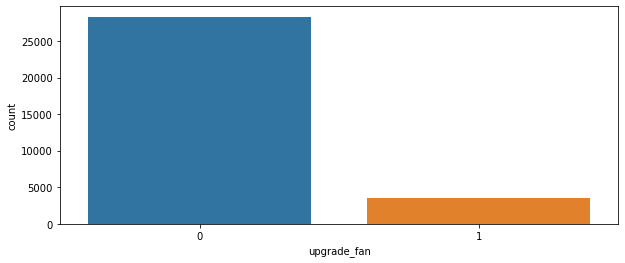

In [9]:
# Distribution of upgrades vs. no upgrades
plt.figure(figsize = (10,4))
sns.countplot(x='upgrade_fan',data=passone)
plt.show()

In [10]:
# Looking at the % of upgrading fans in the dataframe compared to the non-upgraders
noupgrading = len(passone[passone['upgrade_fan']==0])
upgrading = len(passone[passone['upgrade_fan']==1])
pct_of_no_upgrading = noupgrading/(upgrading+noupgrading)
print("percentage of fans that did not upgrade is", pct_of_no_upgrading*100)
pct_of_upgrading = upgrading/(upgrading+noupgrading)
print("percentage of pass one fans that upgraded", pct_of_upgrading*100)

percentage of fans that did not upgrade is 88.83795409588998
percentage of pass one fans that upgraded 11.16204590411002


## Exploring Pass One Fan features

### It appears that those fans that upgraded spent more on pass one tickets and attended more events and subsequently purchased more tickets, however there doesn't seen to be much difference between the 2 classes on the tenure of seasons a fan purchased a pass one ticket

In [11]:
groupby_features = passone[['upgrade_fan','p1_gross','p1_net','num_p1_events','p1_tickets','pass_one_transactions','num_p1_seasons']]
groupby_features.groupby('upgrade_fan').mean()

,p1_gross,p1_net,num_p1_events,p1_tickets,pass_one_transactions,num_p1_seasons
upgrade_fan,,,,,,
0,75.650880,75.562345,1.834841,4.739167,1.840779,1.167774
1,120.138959,119.703494,3.214627,7.463291,3.220534,1.384810


### Some teams don't have lots of upgraded fans that use pass one like Teams 4 and 7

In [12]:
p_groupby_features = passone[['team_id','upgrade_fan']]
total_fans = p_groupby_features.groupby('team_id').count()
upgrade_fans = p_groupby_features.groupby('team_id').sum()
summary = upgrade_fans/total_fans * 100
print( " # Fans that purchased Pass One Tickets", total_fans)
print (" ")
print (" # of Pass One Fans that purchased upgrades ", upgrade_fans)
print (" ")
print (" % of Pass One Fans that purchased Upgrades", summary)

 # Fans that purchased Pass One Tickets          upgrade_fan
team_id             
4              10608
7               7725
8               7094
14              4156
983              422
1047            1219
1082             625
 
 # of Pass One Fans that purchased upgrades           upgrade_fan
team_id             
4                813
7                766
8               1216
14               402
983               72
1047             181
1082             105
 
 % of Pass One Fans that purchased Upgrades          upgrade_fan
team_id             
4           7.664027
7           9.915858
8          17.141246
14          9.672762
983        17.061611
1047       14.848236
1082       16.800000


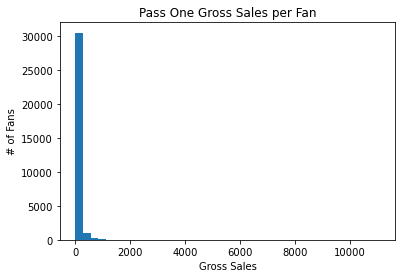

In [13]:
## Distribution of pass one fans gross sales
passone['p1_gross'].plot.hist(bins=40)
plt.title('Pass One Gross Sales per Fan')
plt.xlabel('Gross Sales')
plt.ylabel('# of Fans')
plt.show()

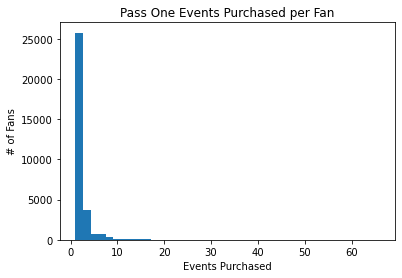

In [14]:
## Distribution of pass one events purchased
passone['num_p1_events'].plot.hist(bins=40)
plt.title('Pass One Events Purchased per Fan')
plt.xlabel('Events Purchased')
plt.ylabel('# of Fans')
plt.show()

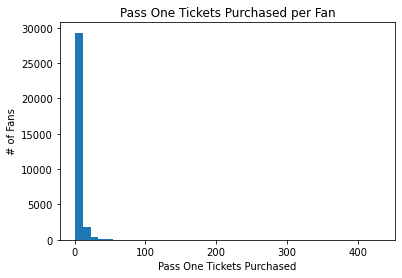

In [15]:
## Distribution of pass one tickets purchased
passone['p1_tickets'].plot.hist(bins=40)
plt.title('Pass One Tickets Purchased per Fan')
plt.xlabel('Pass One Tickets Purchased')
plt.ylabel('# of Fans')
plt.show()

### Something off about the distributions as seen above checking the descriptive statistics for the dataframe below notice that the Avg gross sales is about 80 dollars and the median is around 40 dollars indicating a large skewness of the data due to outliers. The 75th percentile falls at around 90 dollars with a max of 11k.  The others are distorted by extreme values in the data

In [16]:
metrics = passone[['p1_gross','p1_net','avg_gross_spend_per_event','avg_net_spend_per_event','num_p1_events','pass_one_transactions','p1_tickets','num_p1_seasons']]

metrics.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p1_gross,31849.0,80.616660,166.429491,1.0,20.0,40.0,90.0,11069.0
p1_net,31849.0,80.489401,166.307914,1.0,20.0,40.0,90.0,11069.0
avg_gross_spend_per_event,31849.0,39.239916,36.004091,1.0,20.0,30.0,45.0,660.0
avg_net_spend_per_event,31849.0,39.198316,36.009715,1.0,20.0,30.0,45.0,660.0
num_p1_events,31849.0,1.988854,2.323005,1.0,1.0,1.0,2.0,66.0
pass_one_transactions,31849.0,1.994788,2.365054,1.0,1.0,1.0,2.0,76.0
p1_tickets,31849.0,5.043235,7.790262,1.0,2.0,3.0,6.0,431.0
num_p1_seasons,31849.0,1.192000,0.449361,1.0,1.0,1.0,1.0,3.0


### Checking number of observations that are above certain thresholds to determine if we can exclude these outliers

In [17]:
### Some extreme outliers in pass one gross sales need to examine further
above400 = passone[(passone['p1_gross'] >400) & (passone['upgrade_fan']>0)]
print("# of upgraders that spend more than 400 dollars", len(above400))
above600 = passone[(passone['p1_gross'] >600) & (passone['upgrade_fan']>0) ] 
print("# of upgraders that spend more than 600 dollars", len(above600))# 58 obs with upgrades
above1000 = passone[(passone['p1_gross'] >1000) & (passone['upgrade_fan']>0) ] # 18 obs with upgrades
print("# of upgraders that spend more than 1000 dollars", len(above1000))
above1300 = passone[(passone['p1_gross'] >1300) & (passone['upgrade_fan']>0) ] # 7 obs with upgrades
print("# of upgraders that spend more than 1300 dollars", len(above1300))
above1600 = passone[(passone['p1_gross'] >1600) & (passone['upgrade_fan']>0) ] # 4 obs with upgrades
print("# of upgraders that spend more than 1600 dollars", len(above1600))
print(len(above400) + len(above600) + len(above1000) + len(above1300) +len(above1600))

# of upgraders that spend more than 400 dollars 162
# of upgraders that spend more than 600 dollars 58
# of upgraders that spend more than 1000 dollars 18
# of upgraders that spend more than 1300 dollars 7
# of upgraders that spend more than 1600 dollars 4
249


### It appears most high spenders that purchase pass one tickets don't upgrade often.  The high spending pass one fans may not be individual fans but a fan purchasing bulk tickets for a company, etc.

## Outliers in the data need to be dealt with 

Text(0, 0.5, '# of Fans')

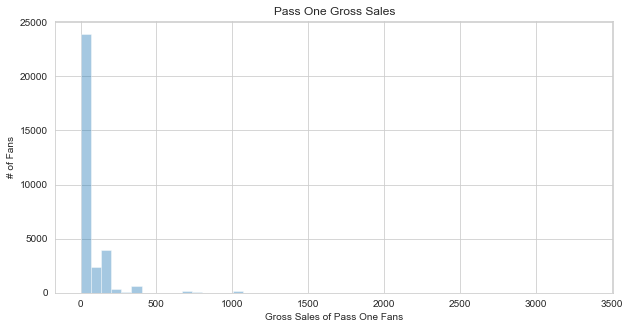

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(passone["p1_gross"][passone['p1_gross'] ],kde=False, bins =50)
plt.title('Pass One Gross Sales')
plt.xlabel('Gross Sales of Pass One Fans')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

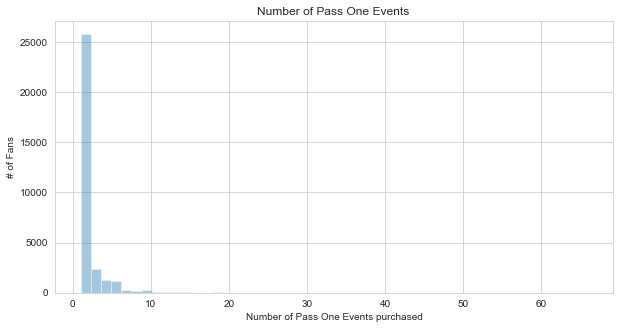

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(passone["num_p1_events"],kde=False, bins =50)
plt.title('Number of Pass One Events ')
plt.xlabel('Number of Pass One Events purchased')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

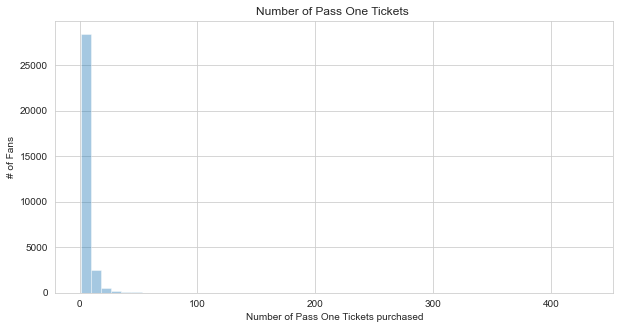

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(passone["p1_tickets"],kde=False, bins =50)
plt.title('Number of Pass One Tickets ')
plt.xlabel('Number of Pass One Tickets purchased')
plt.ylabel('# of Fans')

### Standardizing the features below using Z-scores then eliminating Outliers by using Z-Score <3 

In [21]:
### Going to transform using z-score

import scipy

In [22]:
zscore = passone[['p1_gross','num_p1_events','p1_tickets']]

In [23]:
zscore = scipy.stats.zscore(zscore)

In [24]:
abs_z_scores = np.abs(zscore)

In [25]:
abs_z_scores
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = passone[filtered_entries]


### The new dataframe went from n=31,849 obs to 30,980 obs after removing outliers

In [26]:

new_df.head()

,segment,team_id,product_key,product,team,p1_gross,p1_net,avg_gross_spend_per_event,avg_net_spend_per_event,p1_discounts,num_p1_events,pass_one_transactions,p1_tickets,num_p1_seasons,upgrade_fan,num_upgrades,upgrade_tickets,upgrade_gross,upgrade_net
0,NBA,4,12,Pass One,Team 5,94,94.0,18.8,18.8,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
1,NBA,4,12,Pass One,Team 5,104,104.0,20.8,20.8,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
3,NBA,4,12,Pass One,Team 5,50,50.0,25.0,25.0,0.0,2,2,4,1,0,NaN,NaN,NaN,NaN
4,NBA,4,12,Pass One,Team 5,90,90.0,22.5,22.5,0.0,4,4,10,3,1,1.0,4.0,89.84,89.84
5,NBA,4,12,Pass One,Team 5,60,60.0,20.0,20.0,0.0,3,3,7,1,0,NaN,NaN,NaN,NaN


## Distributions after outliers removed from dataframe

Text(0, 0.5, '# of Fans')

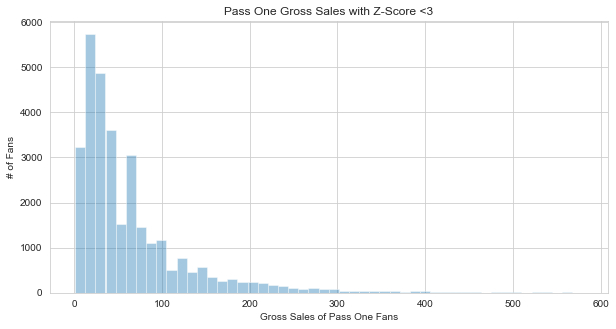

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(new_df["p1_gross"],kde=False, bins =50)
plt.title('Pass One Gross Sales with Z-Score <3')
plt.xlabel('Gross Sales of Pass One Fans')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

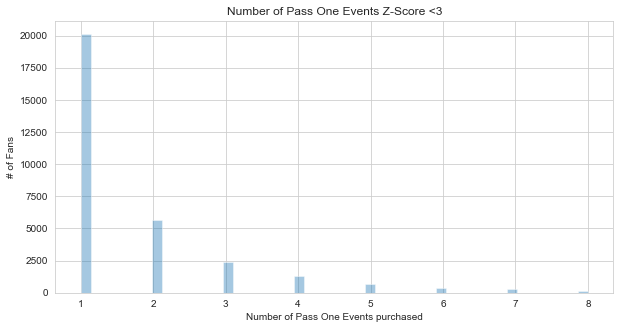

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(new_df["num_p1_events"],kde=False, bins =50)
plt.title('Number of Pass One Events Z-Score <3')
plt.xlabel('Number of Pass One Events purchased')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

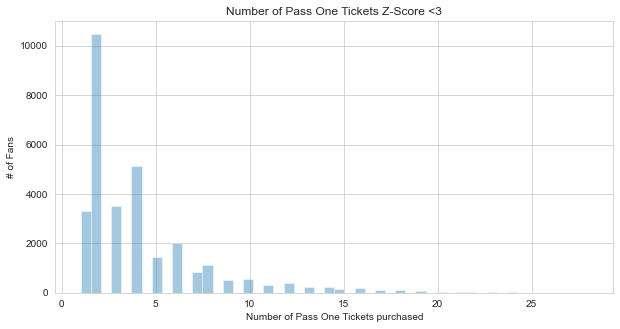

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(new_df["p1_tickets"],kde=False, bins =50)
plt.title('Number of Pass One Tickets Z-Score <3')
plt.xlabel('Number of Pass One Tickets purchased')
plt.ylabel('# of Fans')

### Trimming off some extraneous upgrade variables to check correlations with upgrade_fan

In [30]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30980 entries, 0 to 31848
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   segment                    30980 non-null  object 
 1   team_id                    30980 non-null  int64  
 2   product_key                30980 non-null  int64  
 3   product                    30980 non-null  object 
 4   team                       30980 non-null  object 
 5   p1_gross                   30980 non-null  int64  
 6   p1_net                     30980 non-null  float64
 7   avg_gross_spend_per_event  30980 non-null  float64
 8   avg_net_spend_per_event    30980 non-null  float64
 9   p1_discounts               30980 non-null  float64
 10  num_p1_events              30980 non-null  int64  
 11  pass_one_transactions      30980 non-null  int64  
 12  p1_tickets                 30980 non-null  int64  
 13  num_p1_seasons             30980 non-null  int

### Dataframe with removed outliers called df

In [31]:
df= new_df[['team','p1_gross','p1_net','avg_gross_spend_per_event','avg_net_spend_per_event','num_p1_events','pass_one_transactions','p1_tickets','num_p1_seasons','upgrade_fan']]

In [32]:
df.head()

,team,p1_gross,p1_net,avg_gross_spend_per_event,avg_net_spend_per_event,num_p1_events,pass_one_transactions,p1_tickets,num_p1_seasons,upgrade_fan
0,Team 5,94,94.0,18.8,18.8,5,5,10,2,0
1,Team 5,104,104.0,20.8,20.8,5,5,10,2,0
3,Team 5,50,50.0,25.0,25.0,2,2,4,1,0
4,Team 5,90,90.0,22.5,22.5,4,4,10,3,1
5,Team 5,60,60.0,20.0,20.0,3,3,7,1,0


## Checking correlations of Features with target

In [33]:
df.drop(['upgrade_fan','team'], axis=1).apply(lambda x: x.corr(df.upgrade_fan)).sort_values( ascending=False)

num_p1_events                0.204776
pass_one_transactions        0.204614
p1_tickets                   0.144694
p1_gross                     0.131031
p1_net                       0.130410
num_p1_seasons               0.126876
avg_gross_spend_per_event   -0.006951
avg_net_spend_per_event     -0.007413
dtype: float64

#### Will remove pass_one_transactions, p1_net,avg_gross_spend_per_event, avg_net_spend_per_event due to prevent multicolinearity and due to weak correlation values

In [34]:
modeling_data = new_df[['team','num_p1_events','num_p1_seasons','p1_gross','p1_tickets','upgrade_fan']]

In [35]:
modeling_data.head()

,team,num_p1_events,num_p1_seasons,p1_gross,p1_tickets,upgrade_fan
0,Team 5,5,2,94,10,0
1,Team 5,5,2,104,10,0
3,Team 5,2,1,50,4,0
4,Team 5,4,3,90,10,1
5,Team 5,3,1,60,7,0


### Creating dummy variables to identify different Teams

In [36]:
cat_vars =['team']
for var in cat_vars:
    cat_list=var
    cat_list = pd.get_dummies(modeling_data[var])
    modeling_data1=modeling_data.join(cat_list)
    modeling_data=modeling_data1

cat_vars = ['team']
data_vars = modeling_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
    

In [37]:
modeling_data = modeling_data.drop(('team'), axis=1)
modeling_data

,num_p1_events,num_p1_seasons,p1_gross,p1_tickets,upgrade_fan,Team 1,Team 2,Team 3,Team 4,Team 5,Team 6,Team 7
0,5,2,94,10,0,0,0,0,0,1,0,0
1,5,2,104,10,0,0,0,0,0,1,0,0
3,2,1,50,4,0,0,0,0,0,1,0,0
4,4,3,90,10,1,0,0,0,0,1,0,0
5,3,1,60,7,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31844,1,1,10,1,0,0,0,0,0,1,0,0
31845,1,1,102,3,0,0,0,0,0,0,1,0
31846,1,1,80,2,0,0,0,1,0,0,0,0
31847,1,1,20,2,1,0,0,0,1,0,0,0


### Running Correlations to see if Teams have impact , seems Teams have little correlation with upgrading but the Team 4  had more correlation than the other teams.

In [38]:
modeling_data.drop(['upgrade_fan'], axis=1).apply(lambda x: x.corr(df.upgrade_fan)).sort_values( ascending=False)

num_p1_events     0.204776
p1_tickets        0.144694
p1_gross          0.131031
num_p1_seasons    0.126876
Team 4            0.100426
Team 3            0.028575
Team 1            0.028144
Team 6            0.024415
Team 2           -0.018780
Team 7           -0.023644
Team 5           -0.080022
dtype: float64

### As expected the gross sales of pass one tickets purchased by a fan is positively correlated with number of tickets a fan purchases and the number of events purchased by a fan, The class upgrade_fan has little to no correlation with gross sales which doesn't bode well for this model exercise

In [39]:
modeling_data.drop(['p1_gross'], axis=1).apply(lambda x: x.corr(df.p1_gross)).sort_values( ascending=False)

p1_tickets        0.739462
num_p1_events     0.640599
num_p1_seasons    0.420810
upgrade_fan       0.131031
Team 3            0.117841
Team 2            0.069447
Team 1            0.032879
Team 6            0.018491
Team 7            0.008319
Team 4           -0.044039
Team 5           -0.070471
dtype: float64

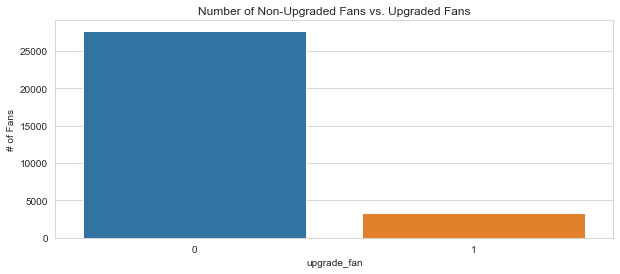

In [40]:
# Distribution of upgrades vs. no upgrades
plt.figure(figsize = (10,4))
sns.countplot(x='upgrade_fan',data=modeling_data)
plt.title('Number of Non-Upgraded Fans vs. Upgraded Fans')
plt.ylabel('# of Fans')
plt.show()

In [41]:
noupgrading = len(modeling_data[modeling_data['upgrade_fan']==0])
upgrading = len(modeling_data[modeling_data['upgrade_fan']==1])
pct_of_no_upgrading = noupgrading/(upgrading+noupgrading)
print("percentage of no upgrading is", pct_of_no_upgrading*100)
pct_of_upgrading = upgrading/(upgrading+noupgrading)
print("percentage of upgrading", pct_of_upgrading*100)

percentage of no upgrading is 89.34796642995481
percentage of upgrading 10.65203357004519


## Although it is pointless to build a model at this point I will do it anyway 

### Trying normal logistic regression first scaling the dating via preprocessing

In [42]:
X= modeling_data[['Team 1','Team 2','Team 3','Team 4','Team 5','Team 6','Team 7','num_p1_events','num_p1_seasons','p1_gross','p1_tickets']]
y =modeling_data['upgrade_fan']

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30980 entries, 0 to 31848
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Team 1          30980 non-null  uint8
 1   Team 2          30980 non-null  uint8
 2   Team 3          30980 non-null  uint8
 3   Team 4          30980 non-null  uint8
 4   Team 5          30980 non-null  uint8
 5   Team 6          30980 non-null  uint8
 6   Team 7          30980 non-null  uint8
 7   num_p1_events   30980 non-null  int64
 8   num_p1_seasons  30980 non-null  int64
 9   p1_gross        30980 non-null  int64
 10  p1_tickets      30980 non-null  int64
dtypes: int64(4), uint8(7)
memory usage: 2.6 MB


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### Running logistic regression model to assess feature statistical significance using p-value of features

In [45]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.312941
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            upgrade_fan   No. Observations:                30980
Model:                          Logit   Df Residuals:                    30969
Method:                           MLE   Df Model:                           10
Date:                Tue, 27 Oct 2020   Pseudo R-squ.:                 0.07735
Time:                        22:11:26   Log-Likelihood:                -9694.9
converged:                       True   LL-Null:                       -10508.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Team 1            -2.4558      0.093    -26.343      0.000      -2.638      -2.273
Team 2           

In [46]:
# Odds Ratios of coefficients from model

print(np.exp(result.params))

Team 1            0.085797
Team 2            0.041162
Team 3            0.086663
Team 4            0.083598
Team 5            0.030580
Team 6            0.102315
Team 7            0.042326
num_p1_events     1.778200
num_p1_seasons    1.140600
p1_gross          1.001346
p1_tickets        0.895907
dtype: float64


###  Interpretation of Odds Ratios
#### For each addtional Pass One Game purchased the odds of upgrading for one of these NBA teams increases 1.8 times
#### The rest of the odd ratios aren't telling much


### All features seem statistically significant shall proceed to model fitting

### Split the data into training set and testing set

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Scaling the Data 

In [48]:
X_train = scaler.fit_transform(X_train)

In [49]:
X_test = scaler.transform(X_test)

### Building model on Training data

In [50]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

### Predictions on Test Data

In [51]:
predictions = logmodel.predict(X_test)

### Classification Report and Confusion Matrix

In [52]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      8294
           1       0.56      0.03      0.06      1000

    accuracy                           0.89      9294
   macro avg       0.73      0.52      0.50      9294
weighted avg       0.86      0.89      0.85      9294

[[8267   27]
 [ 966   34]]


### The accuracy is 89% but this meaningless due to the precision and recall values in the classification report.  The class is highly unbalanced as seen earlier in the countplot and due to the limited number of features available in the model  and the low correlation with the class variable and its features in the model we see the ability for the model to predict fans that upgrade is slightly above random chance with a precision of .56

#### The model correctly classified 8267 Non-Upgrade Fans out of the 8294 Non-Upgraded Fans and correctly classified 34 out of the 1000 upgrade fans for an accuracy of 89%<br>
#### The model incorrectly classified 966 of the Upgraded Fans as Non-Upgraded Fans and incorrectly classified 27 Non-Upgraded Fans as Upgraded Fans

### ROC Curve

### This Curve shows how poorly this model performs , ideally we would like the blue curve to follow more along the y-axis indicating a higher True Positive Rate

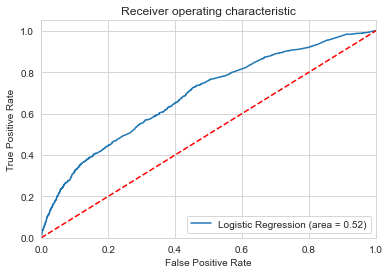

In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Over-Sampling using SMOTE

### Due to imbalance in the target "upgrade_fan" I will use SMOTE technique by creating synthetic samples from upgrade_fan  by randomly choosing one of the k-nearest neighbors and using it to create a similar but randomly modified , new observations

#### The oversampling only occured on training data because by using this technique none of this information in the Test data is being used to create the synthetic observations, therefore no information will leak from test data into model training


#### This is a potentially a good method to balance out classification targets that are unbalanced if and only if you have good data that can predict the target class.  This data doesn't satisfy that criteria but is shown for reference

In [54]:
X= modeling_data[['Team 1','Team 2','Team 3','Team 4','Team 5','Team 6','Team 7','num_p1_events','num_p1_seasons','p1_gross','p1_tickets']]
y =modeling_data['upgrade_fan']

In [55]:
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

over_sampling_data_X,over_sampling_data_y=over_sampling.fit_sample(X_train, y_train)
over_sampling_data_X = pd.DataFrame(data=over_sampling_data_X,columns=columns )
over_sampling_data_y= pd.DataFrame(data=over_sampling_data_y,columns=['upgrade_fan'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(over_sampling_data_X))
print("Number of no upgraders in oversampled data",len(over_sampling_data_y[over_sampling_data_y['upgrade_fan']==0]))
print("Number of upgraders",len(over_sampling_data_y[over_sampling_data_y['upgrade_fan']==1]))
print("Proportion of no upgrader data in oversampled data is ",len(over_sampling_data_y[over_sampling_data_y['upgrade_fan']==0])/len(over_sampling_data_X))
print("Proportion of upgrader data in oversampled data is ",len(over_sampling_data_y[over_sampling_data_y['upgrade_fan']==1])/len(over_sampling_data_X))

length of oversampled data is  38762
Number of no upgraders in oversampled data 19381
Number of upgraders 19381
Proportion of no upgrader data in oversampled data is  0.5
Proportion of upgrader data in oversampled data is  0.5


### Running logistic regression model using SMOTE data

In [56]:
logmodel = LogisticRegression()
logmodel.fit(over_sampling_data_X,over_sampling_data_y)

LogisticRegression()

### Getting Predictions by running x test data

In [57]:
predictions = logmodel.predict(X_test)

### Classification Report and Confusion Matrix

In [58]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      8299
           1       0.19      0.54      0.28       995

    accuracy                           0.70      9294
   macro avg       0.56      0.63      0.55      9294
weighted avg       0.85      0.70      0.75      9294

[[5972 2327]
 [ 453  542]]


### Even worst performance as evident in classification report.  Lost a lot of precision on predicting upgrades from .55 to .17
### accuracy dropped to 71%

### SMOTE is a good option if you have a stronger featured dataset not so much in this case

### ROC Curve

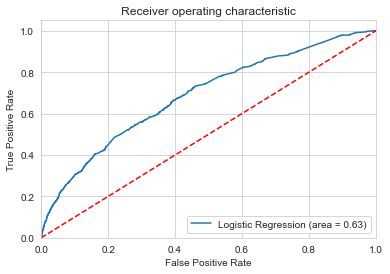

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()